In [1]:
import torch
import torch.nn as nn
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.encoder_mu = nn.Linear(64,2)
        self.encoder_logvar = nn.Linear(64,2)

        self.decoder = nn.Sequential(

            nn.Linear(2,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,28*28),
            nn.Sigmoid()
        )
    def reparameterise(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        return z

    def forward(self,x):
        encoded = self.encoder(x)
        mu = self.encoder_mu(encoded)
        log_var = self.encoder_logvar(encoded)
        z = self.reparameterise(mu, log_var)
        decoded = self.decoder(z)
        return decoded, mu, log_var
model = Vae().to(DEVICE)
print(model)

Using Device: cuda
Vae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (encoder_mu): Linear(in_features=64, out_features=2, bias=True)
  (encoder_logvar): Linear(in_features=64, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
def loss_function(input, output, mu, log_var):
    diff = input - output
    diff_sq = torch.pow(diff, 2)
    rst_error = torch.sum(diff_sq)
    KL = 0.5 * torch.sum(1+log_var-torch.pow(mu,2)-torch.exp(log_var))

    return rst_error - 0.01 * KL

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [4]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
model.train()
EPOCHS = 20
for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0),-1).to(DEVICE)
        optimizer.zero_grad()
        output, mu ,log_var = model(img)
        loss = loss_function(img, output, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch[{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
print("학습완료")


Epoch[1/20], Loss: 1803.5166
Epoch[2/20], Loss: 1801.2298
Epoch[3/20], Loss: 1791.3354
Epoch[4/20], Loss: 1788.1081
Epoch[5/20], Loss: 1778.2852
Epoch[6/20], Loss: 1777.7987
Epoch[7/20], Loss: 1776.0998
Epoch[8/20], Loss: 1772.3149
Epoch[9/20], Loss: 1766.9153
Epoch[10/20], Loss: 1769.4387
Epoch[11/20], Loss: 1760.7594
Epoch[12/20], Loss: 1758.6297
Epoch[13/20], Loss: 1758.9531
Epoch[14/20], Loss: 1764.0745
Epoch[15/20], Loss: 1750.0686
Epoch[16/20], Loss: 1754.4169
Epoch[17/20], Loss: 1750.2463
Epoch[18/20], Loss: 1747.9883
Epoch[19/20], Loss: 1746.7594
Epoch[20/20], Loss: 1746.1607
학습완료


1. 0~9 순서대로 복원 이미지 생성 중...


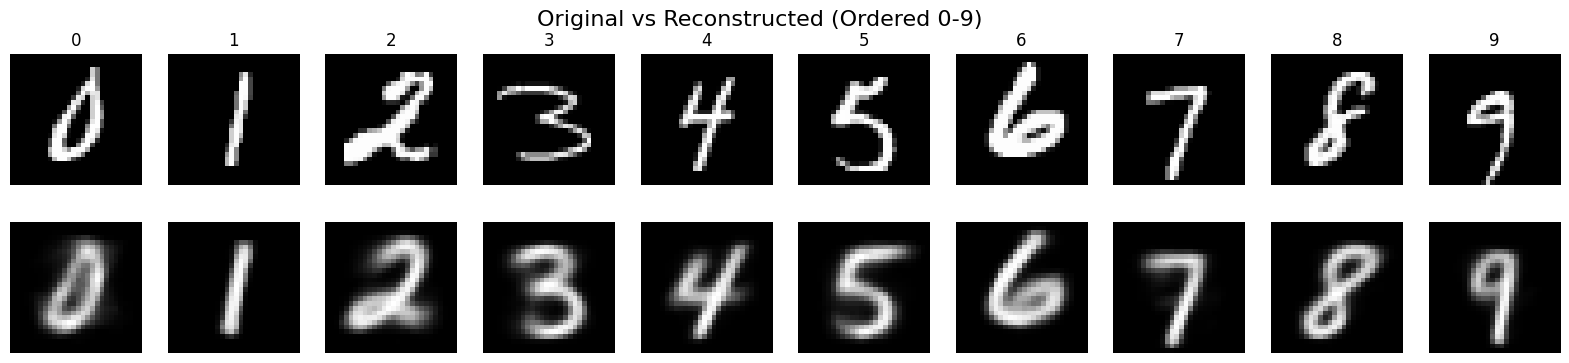

2. Latent Space Manifold 생성 중...


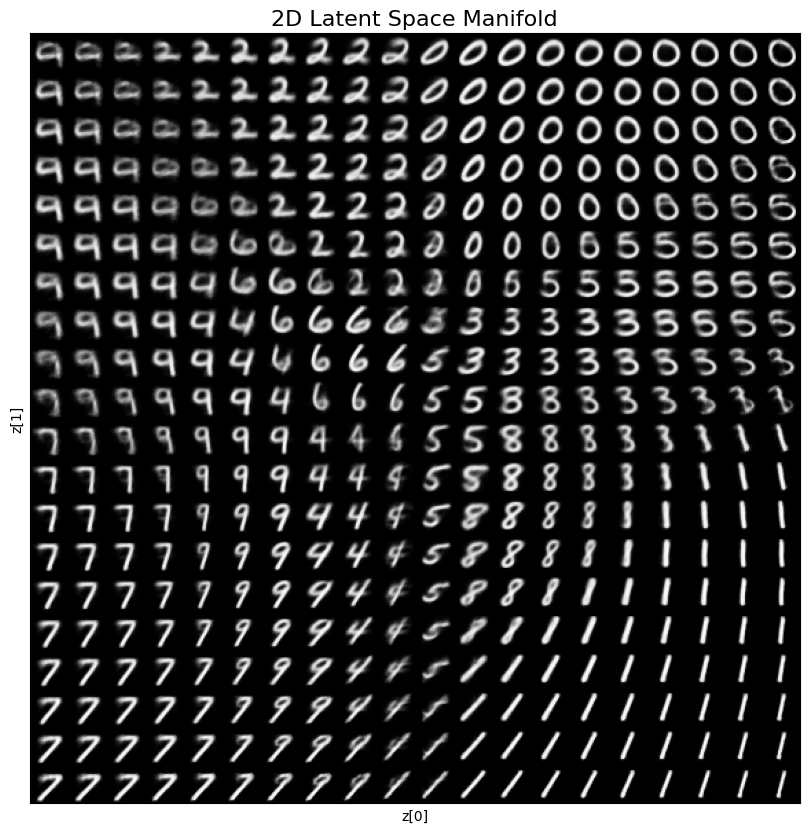

3. Latent Space 분포(Scatter Plot) 그리는 중...


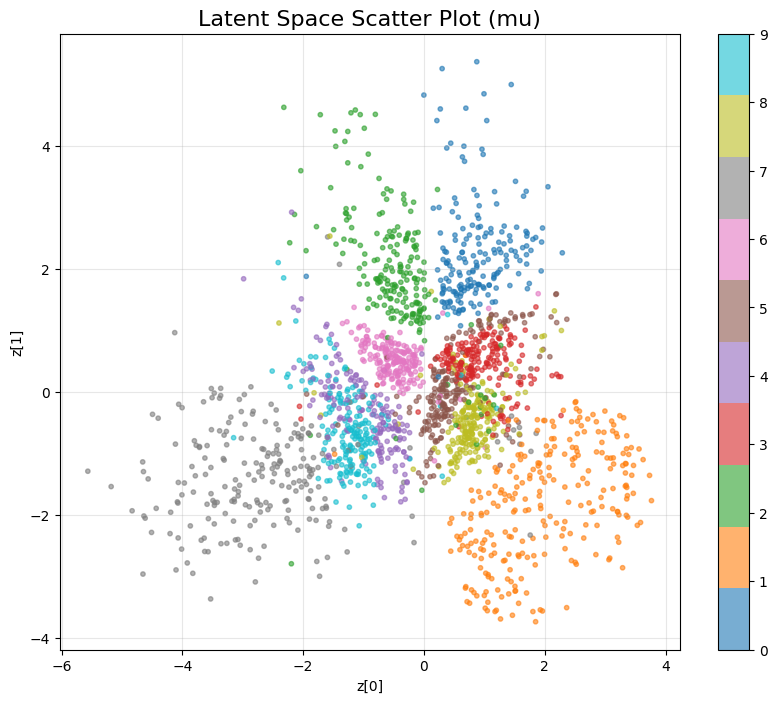

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# ------------------------------------------------------------------
# VAE 결과 시각화 통합 함수
# ------------------------------------------------------------------
def visualize_vae_complete(model, dataloader, device):
    model.eval()
    
    # =============================================================
    # 1. 원본 vs 복원 이미지 비교 (0부터 9까지 순서대로)
    # =============================================================
    print("1. 0~9 순서대로 복원 이미지 생성 중...")
    
    target_digits = {} # {0: img_tensor, 1: img_tensor, ...}
    found_count = 0
    
    # 데이터 로더를 돌면서 0~9 숫자를 하나씩 수집
    with torch.no_grad():
        for images, labels in dataloader:
            if found_count == 10: 
                break
            
            for i in range(len(labels)):
                digit = labels[i].item()
                if digit not in target_digits:
                    target_digits[digit] = images[i]
                    found_count += 1
                    if found_count == 10: 
                        break
    
    # 0부터 9까지 순서대로 텐서 병합
    sorted_images = [target_digits[i] for i in range(10)]
    sorted_images = torch.stack(sorted_images).to(device) # (10, 1, 28, 28)
    sorted_images_flat = sorted_images.view(10, -1)       # (10, 784)
    
    # 모델 통과
    recon_images, _, _ = model(sorted_images_flat)
    recon_images = recon_images.view(10, 28, 28).cpu().detach().numpy()
    original_images = sorted_images.view(10, 28, 28).cpu().numpy()
    
    # 시각화 (상단: 원본, 하단: 복원)
    plt.figure(figsize=(20, 4))
    for i in range(10):
        # 원본
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f"{i}")
        plt.axis('off')
        if i == 0: ax.set_ylabel("Original", fontsize=15)

        # 복원
        ax = plt.subplot(2, 10, i + 1 + 10)
        plt.imshow(recon_images[i], cmap='gray')
        plt.axis('off')
        if i == 0: ax.set_ylabel("Recon", fontsize=15)
    plt.suptitle("Original vs Reconstructed (Ordered 0-9)", fontsize=16)
    plt.show()

    # =============================================================
    # 2. Latent Space Manifold (매니폴드 시각화)
    # =============================================================
    print("2. Latent Space Manifold 생성 중...")
    
    n = 20  # 20x20 그리드
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # 좌표 범위 설정 (-3 ~ 3)
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(3, -3, n) # y축은 위에서 아래로(3 -> -3)
    
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
                decoded = model.decoder(z_sample)
                digit = decoded.view(digit_size, digit_size).cpu().numpy()
                
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.title("2D Latent Space Manifold", fontsize=16)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xticks([])
    plt.yticks([])
    plt.show()

    # =============================================================
    # 3. Latent Space Scatter Plot (산점도)
    # =============================================================
    print("3. Latent Space 분포(Scatter Plot) 그리는 중...")
    
    z_points = []
    labels_list = []
    
    # 테스트 데이터 1000개 정도만 사용하여 분포 확인
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i * images.size(0) > 2000: break # 너무 많으면 느리니 적당히 끊음
            
            images = images.view(images.size(0), -1).to(device)
            # 인코더를 통해 mu 값 추출
            encoded = model.encoder(images)
            mu = model.encoder_mu(encoded) # 사용자 코드 변수명에 맞춤 
            
            z_points.append(mu.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
            
    z_points = np.concatenate(z_points, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Latent Space Scatter Plot (mu)", fontsize=16)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True, alpha=0.3)
    plt.show()
visualize_vae_complete(model, train_loader, DEVICE)